In [5]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
#from django.core.files import File
from datetime import date, timedelta
#import seaborn as sns

In [6]:
RF = 3
TIMEDELTA = 365


In [7]:
def get_cov_mat(stocks):

    today=date.today()
    td = timedelta(365)
    start_date = today-td
    data_dict = dict()
    
    for stock in stocks: 
        yahoo_ticker = stock+'.NS'
        d1 = get_data(yahoo_ticker, start_date = start_date)
        d1 = d1.drop(columns = ['open', 'low', 'high', 'volume', 'adjclose', 'ticker'])
        data_dict[stock] = d1

    data = []
    for key in data_dict:
        data_dict[key] = data_dict[key].rename(columns={'close': key})
        data.append(data_dict[key])

    price_data = pd.concat(data, axis=1, join='inner')

    log_ret = np.log(price_data/price_data.shift(1))

    cov_mat = log_ret.cov()
    cov_mat = cov_mat*252  #assuming 252 trading days in a year

    ret = (log_ret.mean()+1)**252-1

    index_data = get_data("^NSEI", start_date = start_date).filter(["close"]).rename(columns={'close': 'NIFTY'})
    
    return ret, cov_mat, price_data, index_data


In [18]:
class Portfolio(object):
    def __init__(self, secs, weights):

        self.secs = secs
        self.weights = weights

        returns, cov_mat, self.pdata, self.idata  = get_cov_mat(self.secs)

        self.ret = round(np.dot(returns, self.weights)*100, 2)
        self.std = round(np.sqrt(np.dot(self.weights.T, np.dot(cov_mat, self.weights.T)))*100, 2)
        self.sharpe = round((self.ret-RF)/self.std,2)

    def __str__(self):
        return f"Returns: {self.ret}% Std: {self.std}%"

    def plot_performance(self):
        index = 100
        ind_val=[index]
        day = self.weights*100
        port_val = []
        port_val.append(day.sum())

        piret = self.pdata/self.pdata.shift(1)
        inret = self.idata/self.idata.shift(1)

        for i in range(1, len(piret)):
            day = np.array(day*piret.iloc[i])
            port_val.append(day.sum())
            index = index*inret.iloc[i][0]
            ind_val.append(index)
        
        self.pdata['port_val'] = port_val
        self.pdata['ind_val'] = ind_val
        
        index_return = ((np.log(self.idata/self.idata.shift(1)).mean()+1)**252-1)[0]
        std_return_diff = np.std(self.pdata['port_val']/self.pdata['port_val'].shift(1)-self.pdata['ind_val']/self.pdata['ind_val'].shift(1))
        self.inf = (self.ret/100-index_return)/std_return_diff

        plt.plot(self.pdata['port_val'], label="Portfolio")
        plt.plot(self.pdata['ind_val'], label="Nifty")
        sns.lineplot(self.pdata['port_val'])
        #plt.savefig('media\plot.png')


In [19]:
def amt_to_wt(amounts):
    total=sum(amounts)
    return np.array([a/total for a in amounts])


def compute_portfolio(secs, amounts):
    if len(secs) == 0:
        return 0, 0
    port = Portfolio(secs, amt_to_wt(amounts))
    port.plot_performance()
    image = File(open("media\plot.png"), 'rb')
    return Return(port.ret, port.std, port.sharpe, port.inf, image)

def port_post_input(results):
    secs=[]
    amts=[]
    for i in range(len(results)):
        secs.append(results[i].get('sec'))
        amts.append(results[i].get('amt'))
    return secs, amts

class Return:
    def __init__(self, ret, std, sharpe, inf, image):
        self.ret = ret
        self.std = std
        self.sharpe = sharpe
        self.inf = inf
        self.image = image


In [20]:
secs = ['ITC']
amts = [100]
port = Portfolio(secs, amt_to_wt(amts))

C:\Users\Dell\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


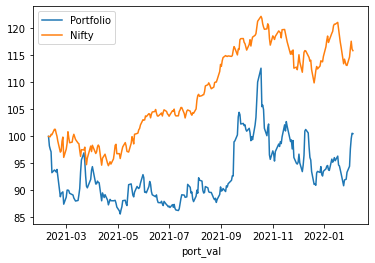

In [21]:
port.plot_performance()

In [22]:
data = port.pdata

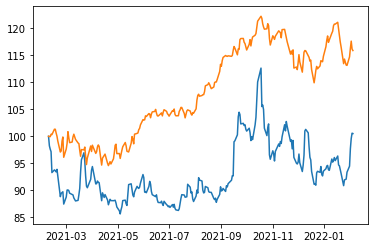

In [24]:
plt.plot(data['port_val'], label="Portfolio")
plt.plot(data['ind_val'], label="Nifty")

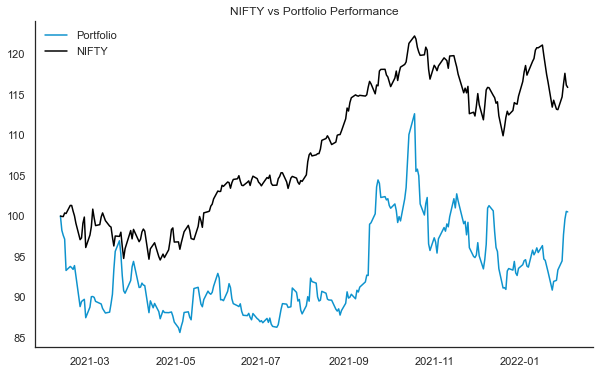

In [101]:
plt.subplots(figsize=(10,6))
sns.set_style("white")
plot = sns.lineplot(data=data[['port_val', 'ind_val']], dashes=['', ''], palette=['#0e93cd', 'black'])
plot.set_title('NIFTY vs Portfolio Performance')
plot.legend(['Portfolio', 'NIFTY'], frameon=False)
sns.despine()
plt.savefig('xxx.png')
